In [ ]:
# 이전 참고: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html(실패)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Requirement load

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import random
import shutil

from tqdm import tqdm

# Data preprocessing
from konlpy.tag import Okt
from gensim.models import FastText # https://wikidocs.net/22883
from sklearn.model_selection import train_test_split

# Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
path = '/content/drive/MyDrive/data/programmers_ai/yujatea/comp_2/'

In [ ]:
train_df = pd.read_csv(os.path.join(path, 'train.csv'))
test_df = pd.read_csv(os.path.join(path, 'test.csv'))

In [ ]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((52690, 3), (13173, 3), (13491, 3))

# Okt 사용자 정의 사전 등록

In [ ]:
# konlpy 설치 경로로 이동
os.chdir('/usr/local/lib/python3.10/dist-packages/konlpy/java')
os.getcwd()

!pwd

/usr/local/lib/python3.10/dist-packages/konlpy/java


In [ ]:
# 따로 등록해논 jar파일 교체
filename = 'open-korean-text-2.1.0.jar'
src = '/content/drive/MyDrive/data/'
dir = '/usr/local/lib/python3.10/dist-packages/konlpy/java/'
shutil.copy(src + filename, dir + filename)

'/usr/local/lib/python3.10/dist-packages/konlpy/java/open-korean-text-2.1.0.jar'

## csv 파일에 정의한 예외 처리 단어 목록 불러오기

In [ ]:
vocab = pd.read_csv(os.path.join(path, 'vocab.csv'))

# Data preprocess

In [ ]:
okt = Okt()

In [ ]:
def tokenize(text):
  result = list()
  # 사용자 정의 지정 표현 수동으로 변환시켜주기
  for key, replace in zip(vocab['key'].values, vocab['replace'].values):
    try:
      text = re.sub(key, replace, text)
    except:
      continue
  # ') 깨문', '병@(#%^신' 처리
  text =re.sub(r'\) 깨문', '대깨문', text)
  text =re.sub(r'병[@#%^]?\(*\)?.*?신', "병신", text)
  text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ]"," ", text) # 한글 아니면 전부 삭제
  text = re.sub('[ㄱ-ㅎ]+', '', text) # 자음으로만 이루어진 경우 삭제
  text = re.sub('[ㅏ-ㅣ]+', '', text) # 모음으로만 이루어진 경우 삭제
  # tokenize
  text = okt.pos(text, norm=True, stem=True)
  for txt, tag in text:
    result.append(txt)
  return result

In [ ]:
clean_train_text = [ tokenize(text) for text in train_df['text']]
clean_val_text = [tokenize(text) for text in val_df['text']]
clean_test_text = [ tokenize(text) for text in test_df['text']]
clean_full_text = clean_train_text + clean_val_text + clean_test_text

In [ ]:
clean_train_label = train_df['label']
clean_val_label = val_df['label']

for text, label in zip(clean_train_text[:5], clean_train_label[:5]):
  print(text, label)

['시바', '외국', '좀', '나가다'] 3
['질퉄', '씹다', '돼지', '뭐', '가', '좋다', '질투', '를'] 1
['왕따', '국가', '클라스', '어디', '안', '가지'] 0
['야', '솔직하다', '손나은', '좋아하다', '엇', '지다', '오늘', '방송', '은', '좀', '안', '이쁘다', '쉬다', '중이', '라', '살', '도', '찌다', '같다'] 1
['역시', '뒤', '가', '더럽다', '뜨다', '끝', '이구나', '문', '정권', '이', '심판', '해주다', '자유', '한국', '당', '스폰놈', '들'] 2


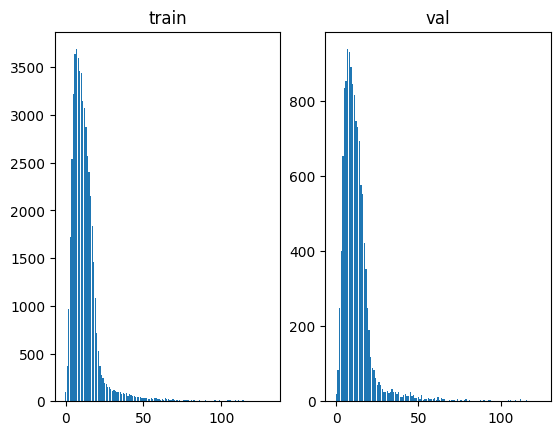

In [ ]:
from collections import Counter

clean_train_text_len = [ len(text) for text in clean_train_text ]
len_counter = Counter(clean_train_text_len)
clean_val_text_len = [len(text) for text in clean_val_text]
len_val_counter = Counter(clean_val_text_len)

fig, axes = plt.subplots(1, 2)
axes[0].set_title('train')
axes[0].bar(len_counter.keys(), len_counter.values())
axes[1].set_title('val')
axes[1].bar(len_val_counter.keys(), len_val_counter.values())
plt.show()

In [ ]:
print(max(len_counter.keys()))
print(max(len_val_counter.keys()))

131
124


# Embedding

In [ ]:
import logging
fast_text_model = FastText(vector_size=120, window=3, min_count=1, sentences=clean_full_text, epochs=20)

In [ ]:
fast_text_model.wv.most_similar("문재인")

[('문재잉', 0.9462137818336487),
 ('뮨재인', 0.9086799025535583),
 ('빼버리긔', 0.9056487083435059),
 ('황동주', 0.9010555148124695),
 ('문재앙', 0.8339293003082275),
 ('조재인', 0.819577157497406),
 ('김재인', 0.8134648203849792),
 ('장재인', 0.8068975210189819),
 ('문죄인', 0.7288060784339905),
 ('문죄잉', 0.7008655071258545)]

In [ ]:
fast_text_model.wv.most_similar("씨발")

[('쇠키', 0.5431351065635681),
 ('굼미', 0.5397842526435852),
 ('디뚱디뚱', 0.5384495854377747),
 ('썅', 0.5378517508506775),
 ('멍키', 0.5354181528091431),
 ('흥흥', 0.5314046144485474),
 ('어흥', 0.529941976070404),
 ('싀방새', 0.5284655690193176),
 ('시발련', 0.5219365954399109),
 ('업늠년', 0.5165977478027344)]

In [ ]:
fast_text_model.wv.most_similar("짱깨")

[('죳짱깨', 0.9775006175041199),
 ('짱깨샠', 0.9756991267204285),
 ('짱깨몽', 0.91025310754776),
 ('짱개', 0.901069164276123),
 ('짱개몽', 0.8942984938621521),
 ('짱개쌩쑈', 0.8246316909790039),
 ('짱개헥히', 0.7807087302207947),
 ('짱깨빠이러스', 0.7439532279968262),
 ('중국사', 0.7386832237243652),
 ('중국화', 0.7170745134353638)]

In [ ]:
fast_text_model.wv.most_similar("쪽빠리")

[('빠리', 0.9939755201339722),
 ('읊어야', 0.7578256130218506),
 ('찬입좀', 0.7576574683189392),
 ('섬숭', 0.7558352947235107),
 ('사당', 0.7524204850196838),
 ('히로히토', 0.7307947874069214),
 ('방사성폐기물', 0.7277071475982666),
 ('븡유', 0.7240186333656311),
 ('기리', 0.7234997153282166),
 ('잡빨', 0.7221040725708008)]

In [ ]:
similar_dict = dict()
similar_set = set()
for txt in clean_full_text :
    similar_set = similar_set.union(set(txt))

for key in similar_set:
    val = fast_text_model.wv.most_similar(key, topn=3)[-1][0]
    similar_dict[key] = fast_text_model.wv[val]

In [ ]:
del similar_set

In [ ]:
print(fast_text_model.wv['쪽빠리'])
print(fast_text_model.wv['쪽빠리'].shape)

[-0.06389026  0.04500434 -0.00336788 -0.07011577  0.00684014 -0.04628779
  0.03954049  0.08949376 -0.02207632 -0.02119667 -0.02707621  0.06219692
  0.12520044 -0.01038703  0.00262161 -0.02077118  0.0477993   0.01361214
 -0.04481038 -0.02382416 -0.05739577 -0.01291697  0.025447   -0.04549376
  0.03788114 -0.08450854  0.00393287  0.01166568  0.05684503  0.02690951
 -0.02875089 -0.10163615  0.01511376  0.01273058 -0.04564739 -0.01741087
  0.02534046 -0.01523237 -0.0478566   0.02709464  0.06904969 -0.01709897
 -0.02197384 -0.04712313  0.0514646   0.03705085 -0.02326037 -0.02643042
 -0.04925787 -0.01725392 -0.07085213 -0.06704213 -0.00835842  0.00125089
 -0.03403071  0.01212553 -0.00406797  0.00203431 -0.00593713  0.0343708
 -0.03484907  0.01621399 -0.00893262  0.08969361 -0.01572232 -0.03237139
  0.0046663   0.06345741 -0.04032506  0.01834911  0.12487527 -0.04776488
  0.00373852 -0.03189673  0.03648754  0.07174224  0.06016338 -0.07558227
  0.01505143  0.01445485  0.01008301 -0.01929329  0.

In [ ]:
print(fast_text_model.wv[''])
print(fast_text_model.wv[' '])
print(fast_text_model.wv['          '])
# 공백 문자열도 임베딩이 됬다. 뭐지?

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 6.8579097e-03  5.1391660e-03  3.3224632e-03 -9.9714601e-04
 -1.7150134e-03 -6.1970414e-03  7.4479380e-04  2.1911610e-03
 -2.3570149e-03 -4.4189375e-03 -7.1536391e-03 -5.2145184e-03
  7.6348702e-03  4.4242879e-03 -3.6876709e-03 -6.8985322e-04
  4.7620732e-04  1.5681366e-03  4.5127203e-03 -2.1763097e-03
  7.9651615e-03 -1.5379946e-03  6.6705584e-03 -7.1832817e-03
 -6.0457992e-03  2.9051176e-03  4.4009327e-03  3.0019234e-03
 -5.5124750e-03  4.7765006e-03  6.6769142e-03 -3.7890344e-03
 -1.1244913e-04 -7.6666712e-03  2.7249039e-03  5.5168760e-03
 -7.4251681e-03  7.5159906e-03  6.9649289e-03  5.2494355e-03
 -7.4150361e-04  2.70068

In [ ]:
epochs = 40
max_len = 120

In [ ]:
class CustomDataset(Dataset) :
    def __init__(self, text, fasttext_model, max_len = 120, label=list(), mode='train') :
        self.text = list()
        self.text_len = list()
        
        # self.orig_text = text # 원본 text
        self.mode = mode # train mode
        # self.random_val = random_val
        
        for txt in tqdm(text) :
            self.text_len.append(min(max_len, len(txt)))
            if len(txt) < max_len :
                txt = txt + [""] * (max_len - len(txt))
            txt = txt[:max_len]
            txt = fasttext_model[txt]
            self.text.append(txt)
        
        if self.mode != 'test' :
            self.label = label
        else :
            self.label = [0]*len(self.text)

    def __getitem__(self, idx) :
        if self.mode == 'train' :
            item_text, item_label = self.text[idx], self.label[idx]
            # orig_text = self.orig_text[idx]
            # item_len = self.text_len[idx]
              
            # change_val = int(item_len * self.random_val)
            # change_idx_list = random.sample(range(item_len), change_val)
            # for _idx in change_idx_list :
                # item_text[_idx] = similar_dict[orig_text[_idx]]
              
            return item_text, item_label

        else :
            return self.text[idx], self.label[idx]
      
    def __len__(self) :
        return len(self.text)

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

train_dset = CustomDataset(text=clean_train_text, fasttext_model = fast_text_model.wv, max_len = max_len, label = clean_train_label, mode = 'train')
val_dset = CustomDataset(text=clean_val_text, fasttext_model = fast_text_model.wv, max_len = max_len, label = clean_val_label, mode = 'val')
test_dset = CustomDataset(text=clean_test_text,fasttext_model = fast_text_model.wv, max_len = max_len, mode = 'test')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  3%|▎         | 1370/52690 [04:11<2:46:31,  5.14it/s]WARNING:gensim.models.fasttext:could not extract any ngrams from '', returning origin vector
